In [1]:
!pip install langdetect
!pip install spacy
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 8.1 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 12.2 MB/s eta 0:00:01
     ------------------------ --------------- 7.9/12.8 MB 15.5 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 18.1 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 16.6 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# DATA PREPROCESSING

import pandas as pd  
import numpy as np
import re                                 
import spacy                              
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException        



In [3]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")  

In [4]:
# Load the dataset
df = pd.read_csv(r'data/chatgpt_review.csv')

In [5]:
# Show basic info
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-12-24,East list local interesting far magazine father.,Impressive natural language understanding. Alm...,1,darren55,25,9,Google Play,de,Nepal,2.0.4,No
1,2024-07-26,Road determine picture figure hard experience ...,Sometimes gives wrong answers or outdated info...,2,davistyler,35,14,Flipkart,es,Panama,2.6.5,No
2,2024-08-22,Policy social past analysis whole.,Great tool for generating content quickly. Int...,5,andrea59,94,10,App Store,es,Denmark,4.2.2,No
3,2025-04-24,News financial billion four foreign.,Great tool for generating content quickly. Sta...,3,dcooper,50,15,Amazon,de,Brunei Darussalam,4.4.2,No
4,2024-08-15,To skill she case sing stop likely.,Excellent for language translation and grammar...,1,christine79,33,11,Flipkart,fr,United States Minor Outlying Islands,5.1.1,Yes


In [6]:
# row and column 

df.shape

(50, 12)

In [7]:
print(df.isnull().sum())

date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length        0
platform             0
language             0
location             0
version              0
verified_purchase    0
dtype: int64


In [8]:
print(df.duplicated())

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
dtype: bool


In [9]:
## remove whitespace

def remove_whitespace(text):
    return " ".join(text.split())

df['review']=df['review'].apply(remove_whitespace)

In [10]:
# Language Detection

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

df['detect_language'] = df['review'].apply(detect_language)

# Filter only English reviews
df = df[df['detect_language'] == 'en']
print(df['detect_language'].value_counts())

detect_language
en    50
Name: count, dtype: int64


In [11]:
# Basic Text Cleaning

def clean_text(text):
    
    # Remove non-alphabetic characters (keep spaces)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()
    return text

df['review'] = df['review'].apply(clean_text)

In [12]:
# Tokenization + Lemmatization + Stopword Removal with spaCy

def spacy_preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

df['review'] = df['review'].apply(spacy_preprocess)


In [13]:
# Replace newlines (\n) and extra spaces around them with a single space

df['review'] = df['review'].str.replace(r'\s*\n\s*', ' ', regex=True)

In [14]:
## read column name of entire dataset

df.columns

Index(['date', 'title', 'review', 'rating', 'username', 'helpful_votes',
       'review_length', 'platform', 'language', 'location', 'version',
       'verified_purchase', 'detect_language'],
      dtype='object')

In [15]:
%pip install wordcloud

# EXPLORATORY DATA ANALYSIS (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

Note: you may need to restart the kernel to use updated packages.


C:\Users\vigne\AppData\Local\Temp\ipykernel_23860\3135755171.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rating', palette='coolwarm')


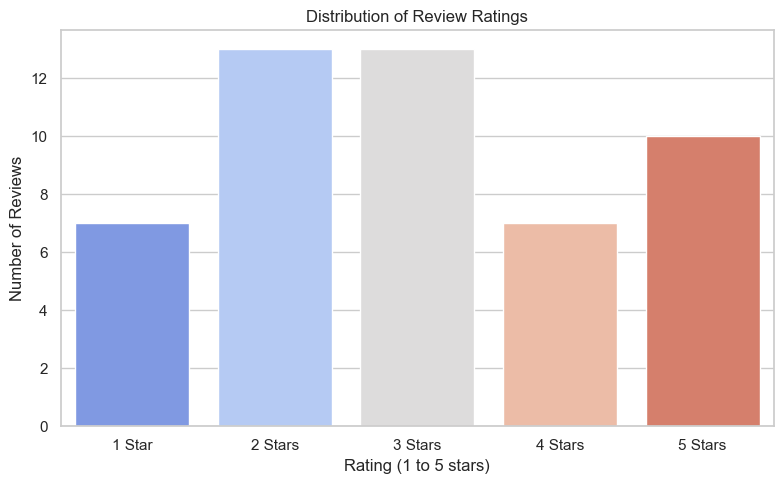

In [16]:
# 1. What is the distribution of review ratings? 
# Set Seaborn style
sns.set(style="whitegrid")

# Plot the distribution of review ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='rating', palette='coolwarm')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating (1 to 5 stars)')
plt.ylabel('Number of Reviews')
plt.xticks([0, 1, 2, 3, 4], ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'])
plt.tight_layout()
plt.show()


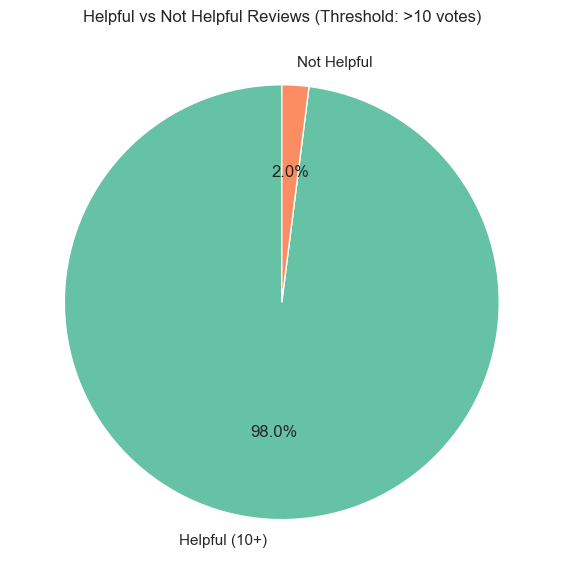

In [17]:
# 2. How many reviews were marked as helpful (above a certain threshold)?

# Define threshold
threshold = 10

# Count helpful vs not helpful
helpful_counts = pd.Series([
    'Helpful (10+)' if x > threshold else 'Not Helpful' 
    for x in df['helpful_votes']
]).value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
colors = ['#66c2a5', '#fc8d62']
helpful_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Helpful vs Not Helpful Reviews (Threshold: >10 votes)')
plt.ylabel('')
plt.tight_layout()
plt.show()

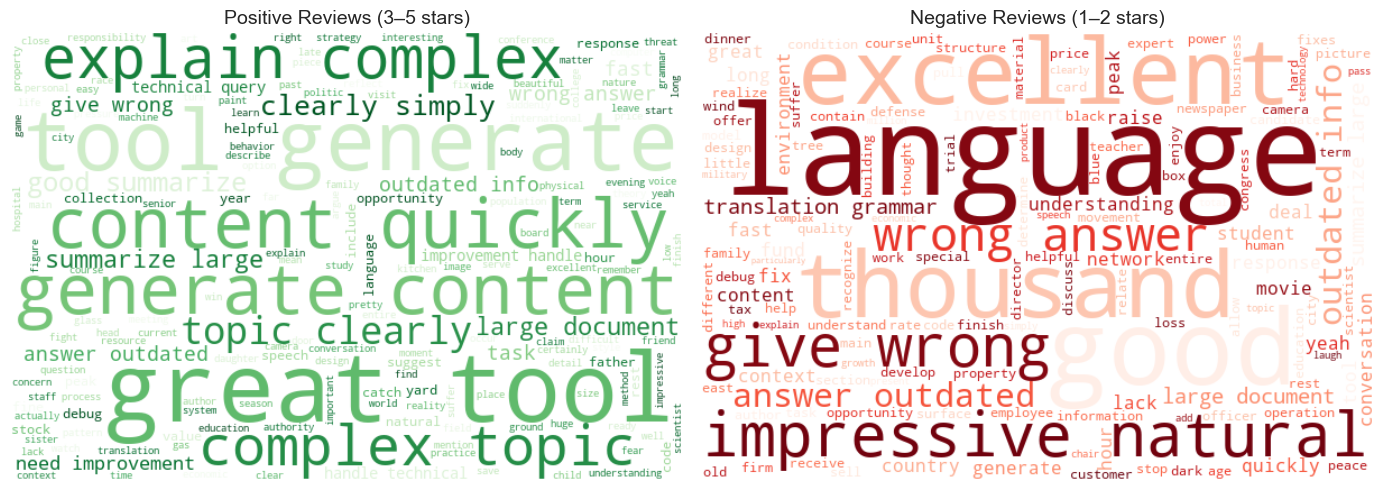

In [18]:
# 3. Most Common Keywords in Positive vs. Negative Reviews

# Filter based on ratings
positive_reviews = df[df['rating'] >= 3]['review']
negative_reviews = df[df['rating'] <= 2]['review']

# Join all text
positive_text = ' '.join(positive_reviews.dropna().astype(str))
negative_text = ' '.join(negative_reviews.dropna().astype(str))

# Create word clouds
plt.figure(figsize=(14, 6))

# Positive word cloud
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=600, height=400, background_color='white', colormap='Greens').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews (3–5 stars)", fontsize=14)

# Negative word cloud
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews (1–2 stars)", fontsize=14)

plt.tight_layout()
plt.show()


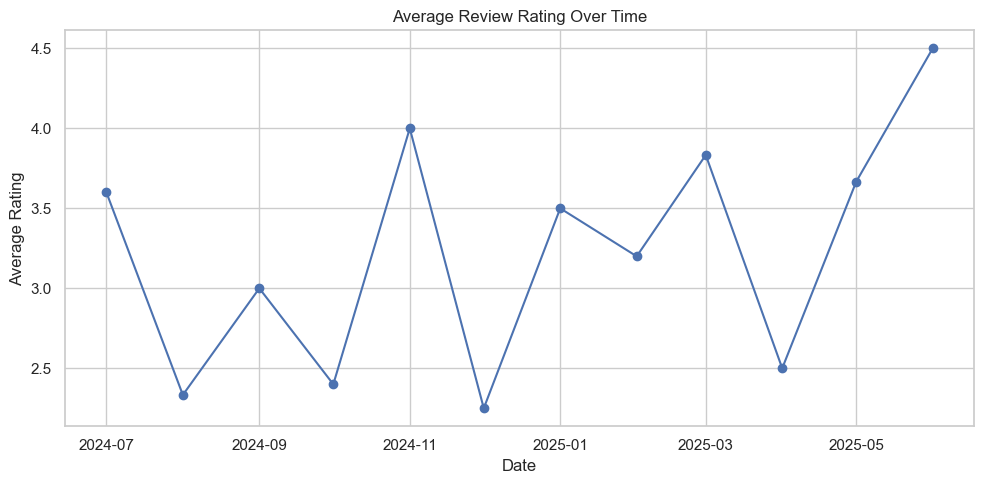

In [19]:
# 4. How has the average rating changed over time?

# Convert date column to datetime format 
df['date'] = pd.to_datetime(df['date'])

# Group by time — weekly or monthly
avg_rating_over_time = df.groupby(df['date'].dt.to_period('M'))['rating'].mean().reset_index()
avg_rating_over_time['date'] = avg_rating_over_time['date'].dt.to_timestamp()

# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(avg_rating_over_time['date'], avg_rating_over_time['rating'], marker='o', linestyle='-')
plt.title('Average Review Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\vigne\AppData\Local\Temp\ipykernel_23860\1801664226.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_by_location.values, y=avg_rating_by_location.index, palette="coolwarm")


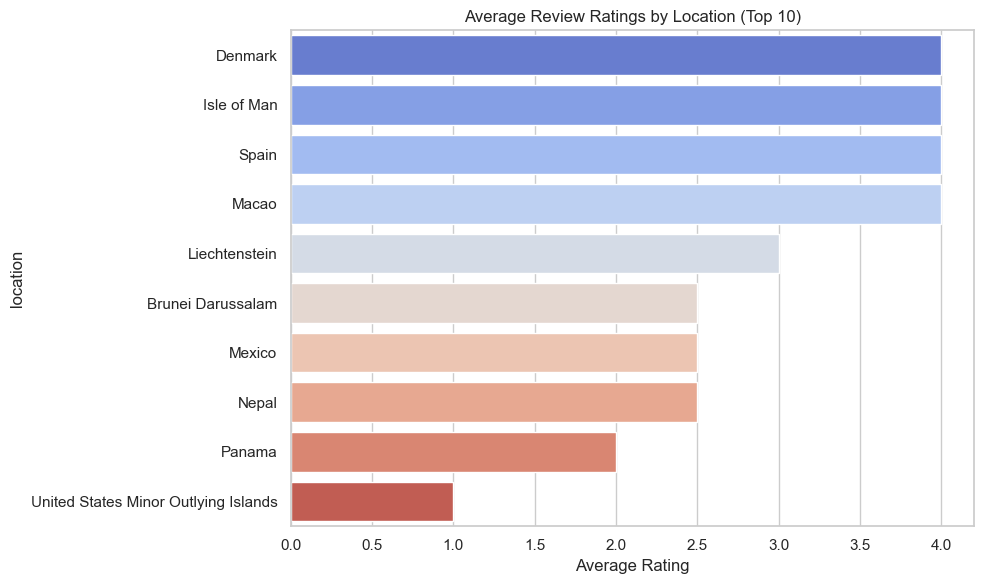

In [20]:
# 5. How Do Ratings Vary by User Location?

# Top 10 countries by review count
top_countries = df['location'].value_counts().nlargest(10).index
filtered_df = df[df['location'].isin(top_countries)]

# Average rating by location
avg_rating_by_location = filtered_df.groupby('location')['rating'].mean().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_rating_by_location.values, y=avg_rating_by_location.index, palette="coolwarm")
plt.xlabel('Average Rating')
plt.title('Average Review Ratings by Location (Top 10)')
plt.tight_layout()
plt.show()


C:\Users\vigne\AppData\Local\Temp\ipykernel_23860\4079748808.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='platform', y='rating', data=avg_rating_by_platform, palette='Set2')


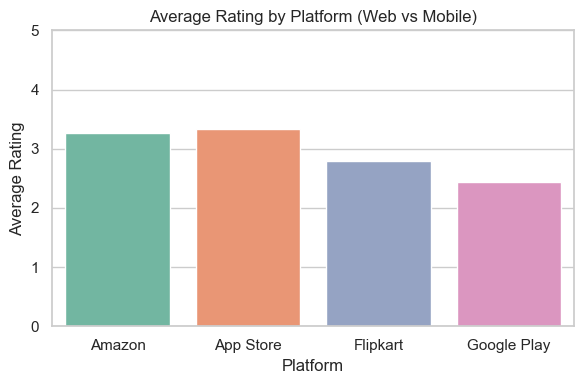

In [21]:
# 6. Which Platform Gets Better Reviews? (Web vs. Mobile)

# Group by platform and calculate average ratings
avg_rating_by_platform = df.groupby('platform')['rating'].mean().reset_index()

# Bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='platform', y='rating', data=avg_rating_by_platform, palette='Set2')
plt.title('Average Rating by Platform (Web vs Mobile)')
plt.ylabel('Average Rating')
plt.xlabel('Platform')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()


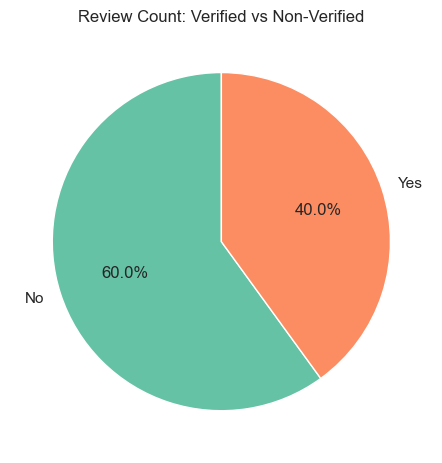

In [22]:
# 7. Are Verified Users More Satisfied Than Non-Verified Ones?

# Distribution of Verified vs Non-Verified Reviews
verified_counts = df['verified_purchase'].value_counts()

# Plotting side-by-side pie charts
plt.figure(figsize=(12, 6))
colors = ['#66c2a5', '#fc8d62']

# Subplot 1: Review count
plt.subplot(1, 2, 1)
verified_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    labels=verified_counts.index,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Review Count: Verified vs Non-Verified')
plt.ylabel('');

C:\Users\vigne\AppData\Local\Temp\ipykernel_23860\2251875569.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='review_length', data=df, palette='Blues')


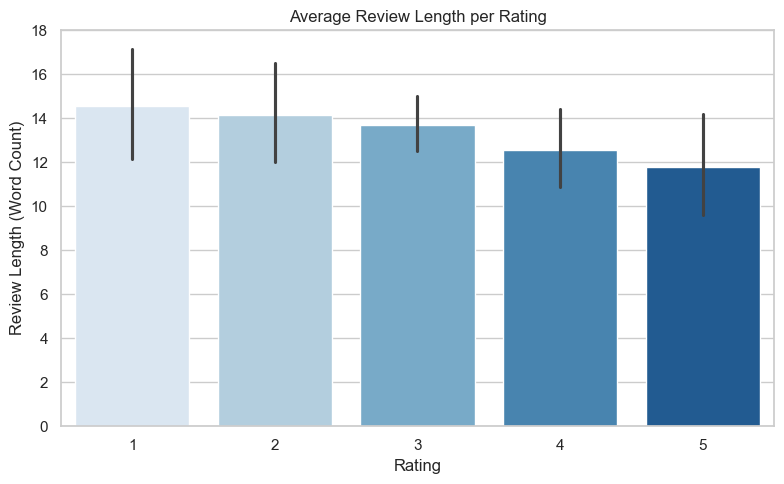

In [23]:
# 8. Average Length of Reviews per Rating Category

# Bar Chart: Average Review Length by Rating
plt.figure(figsize=(8, 5))
sns.barplot(x='rating', y='review_length', data=df, palette='Blues')
plt.title('Average Review Length per Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length (Word Count)')
plt.tight_layout()
plt.show()


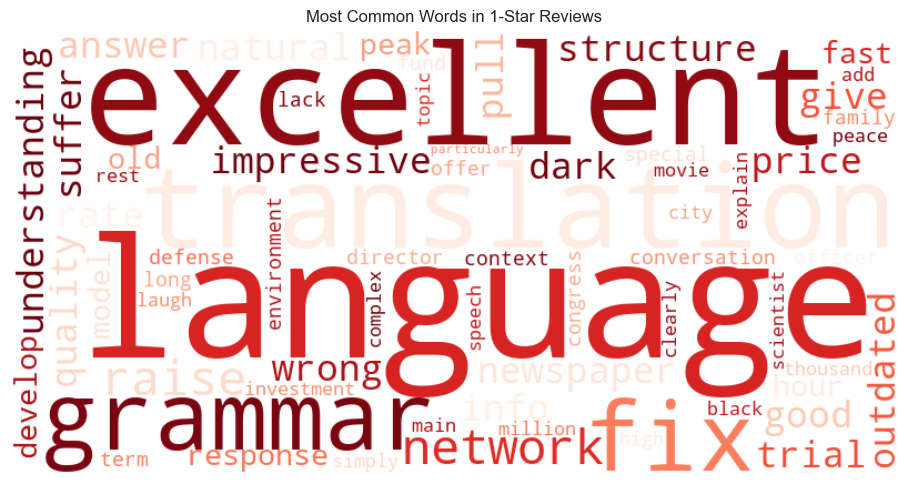

In [24]:
# 9. Most Mentioned Words in 1-Star Reviews

# Filter 1-star reviews
one_star_text = ' '.join(df[df['rating'] == 1]['review'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(one_star_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in 1-Star Reviews')
plt.tight_layout()
plt.show()


C:\Users\vigne\AppData\Local\Temp\ipykernel_23860\1045151504.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='version', y='rating', data=version_avg, palette='viridis')


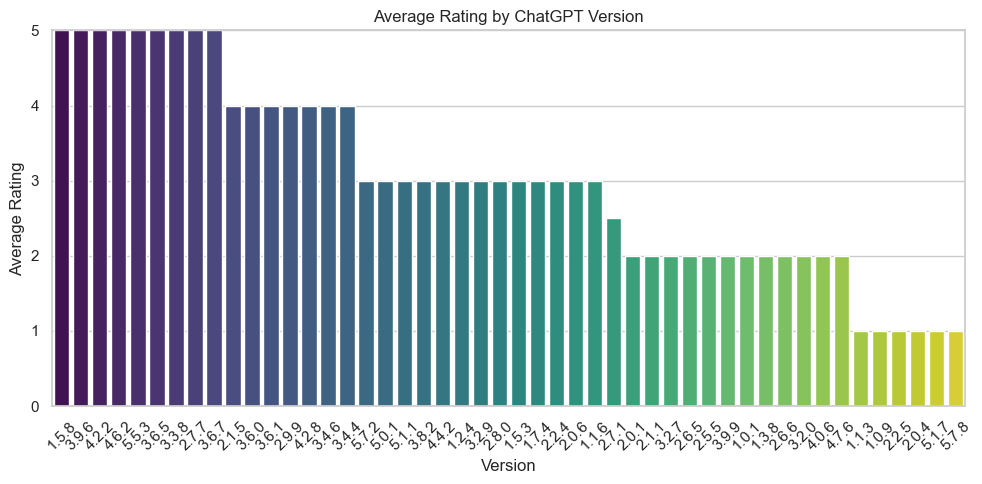

In [25]:
# 10. Which ChatGPT Version Received the Highest Average Rating?

# Group by version and calculate average rating
version_avg = df.groupby('version')['rating'].mean().sort_values(ascending=False).reset_index()

# Bar plot: Versions vs average ratings
plt.figure(figsize=(10, 5))
sns.barplot(x='version', y='rating', data=version_avg, palette='viridis')
plt.title('Average Rating by ChatGPT Version')
plt.xlabel('Version')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.tight_layout()
plt.show()


In [26]:
# Sentiment Labeling

def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(label_sentiment)
print(df[['rating', 'sentiment']].head(10))

# Ratings 1 or 2 → 'negative'
# Rating 3 → 'neutral'
# Ratings 4 or 5 (or anything above 3) → 'positive'

   rating sentiment
0       1  negative
1       2  negative
2       5  positive
3       3   neutral
4       1  negative
5       4  positive
6       2  negative
7       3   neutral
8       1  negative
9       2  negative


In [27]:
 ##save clean csv file
df.to_csv(r'data/cleaned_data.csv', index=False)

C:\Users\vigne\AppData\Local\Temp\ipykernel_23860\472746610.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='pastel')


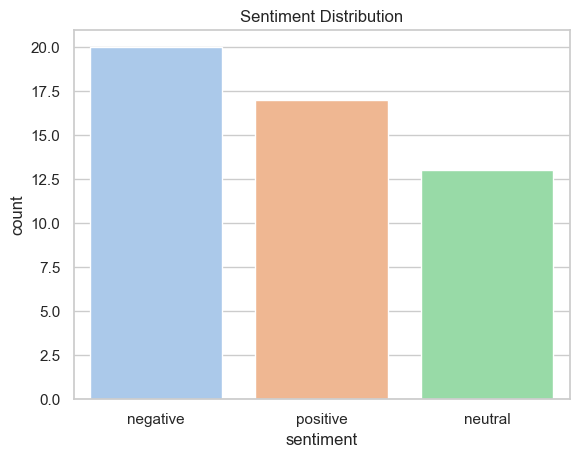

In [28]:
# Count of Each Sentiment
sns.countplot(data=df, x='sentiment', palette='pastel')
plt.title('Sentiment Distribution')
plt.show()

C:\Users\vigne\AppData\Local\Temp\ipykernel_23860\601868859.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_freq.sort_values(by='frequency', ascending=False), x='frequency', y='word', palette='Blues_r')


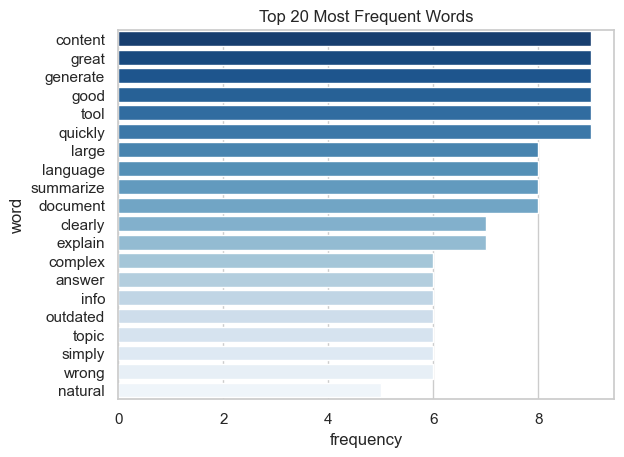

In [29]:
# Most Frequent Words (Histogram)
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['review'])

# Convert to DataFrame
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

# Plot
sns.barplot(data=word_freq.sort_values(by='frequency', ascending=False), x='frequency', y='word', palette='Blues_r')
plt.title('Top 20 Most Frequent Words')
plt.show()


In [30]:
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Features and target
X_text = df['review']
y = df['sentiment']

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(X_text)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf.toarray(), y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)


🔹 Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.50      0.67      0.57         6
           2       0.44      0.67      0.53         6

    accuracy                           0.50        18
   macro avg       0.65      0.50      0.46        18
weighted avg       0.65      0.50      0.46        18

Accuracy: 0.5
AUC-ROC Score (OvR): 0.736111111111111


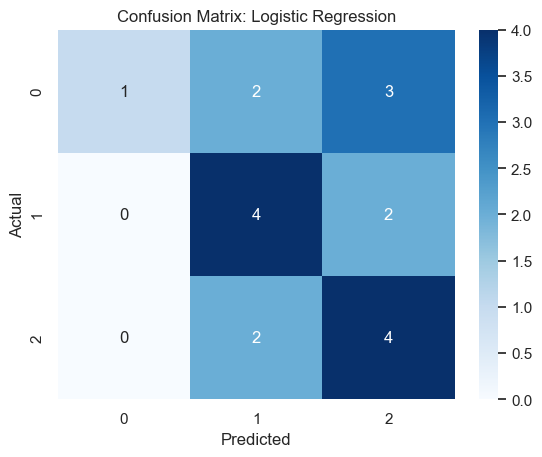

Cross-validation Accuracy Scores: [0.83333333 0.41666667 0.33333333 0.66666667 0.75      ]
Mean CV Accuracy: 0.6

🔹 Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       1.00      0.33      0.50         6
           2       0.36      0.67      0.47         6

    accuracy                           0.50        18
   macro avg       0.65      0.50      0.51        18
weighted avg       0.65      0.50      0.51        18

Accuracy: 0.5
AUC-ROC Score (OvR): 0.75


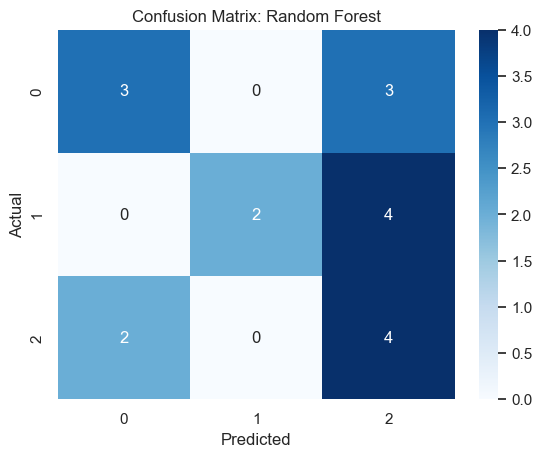

Cross-validation Accuracy Scores: [0.5        0.33333333 0.33333333 0.5        0.75      ]
Mean CV Accuracy: 0.4833333333333333

🔹 Model: Naive Bayes
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.50      0.67      0.57         6
           2       0.44      0.67      0.53         6

    accuracy                           0.50        18
   macro avg       0.65      0.50      0.46        18
weighted avg       0.65      0.50      0.46        18

Accuracy: 0.5
AUC-ROC Score (OvR): 0.7453703703703706


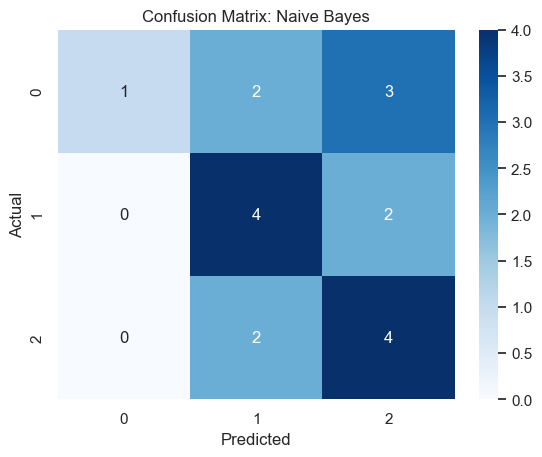

Cross-validation Accuracy Scores: [0.75       0.33333333 0.25       0.58333333 0.75      ]
Mean CV Accuracy: 0.5333333333333333


In [32]:
# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}

# Loop through models
for name, model in models.items():
    print(f"\n🔹 Model: {name}")
    
    # Fit
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Accuracy
    print("Accuracy:", accuracy_score(y_test, y_pred))
    
    # AUC-ROC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        print("AUC-ROC Score (OvR):", auc)
    else:
        print("AUC-ROC not available (model does not support probability prediction)")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Cross-validation Accuracy
    scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
    print("Cross-validation Accuracy Scores:", scores)
    print("Mean CV Accuracy:", scores.mean())



🔹 Model: MLPClassifier
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.33      1.00      0.50         6
           2       0.00      0.00      0.00         6

    accuracy                           0.33        18
   macro avg       0.11      0.33      0.17        18
weighted avg       0.11      0.33      0.17        18

Accuracy: 0.3333333333333333
AUC-ROC Score (OvR): 0.5


c:\Users\vigne\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\vigne\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\vigne\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

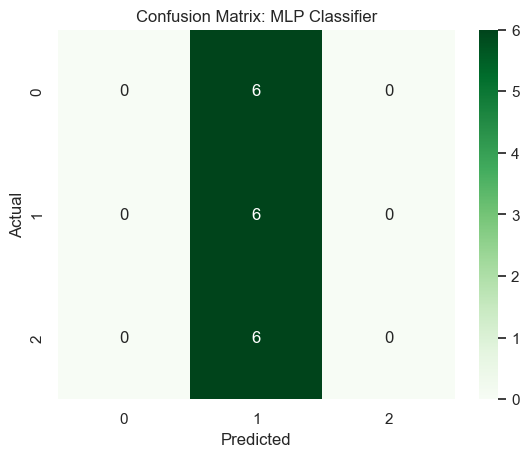

Cross-validation Accuracy Scores: [0.33333333 0.33333333 0.33333333 0.41666667 0.33333333]
Mean CV Accuracy: 0.35


In [33]:
from sklearn.neural_network import MLPClassifier

# Initialize MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64),  # two hidden layers
                          activation='relu',
                          solver='adam',
                          max_iter=300,
                          early_stopping=True,
                          n_iter_no_change=10,
                          validation_fraction=0.1,
                          random_state=42)

print("\n🔹 Model: MLPClassifier")

# Fit the model
mlp_model.fit(X_train, y_train)

# Predict on test set
y_pred_mlp = mlp_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))

# AUC-ROC Score
if hasattr(mlp_model, "predict_proba"):
    y_proba_mlp = mlp_model.predict_proba(X_test)
    auc_mlp = roc_auc_score(y_test, y_proba_mlp, multi_class='ovr')
    print("AUC-ROC Score (OvR):", auc_mlp)
else:
    print("AUC-ROC not available (model does not support probability prediction)")

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: MLP Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Cross-validation (optional)
from sklearn.model_selection import cross_val_score
cv_scores_mlp = cross_val_score(mlp_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-validation Accuracy Scores:", cv_scores_mlp)
print("Mean CV Accuracy:", cv_scores_mlp.mean())


In [34]:
import pickle

# Assuming `model` is your trained LogisticRegression instance
with open('model/logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✅ Logistic Regression model saved!")



✅ Logistic Regression model saved!


In [35]:
with open('model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)  # `tfidf` is your trained TfidfVectorizer
print("✅ TF-IDF vectorizer saved!")


✅ TF-IDF vectorizer saved!
